# JQA Text Analysis -- Tf-idf

In [1]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os, pickle, string
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats
import matplotlib.pyplot as plt

# Import NLTK packages.
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import sklearn packages.
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Library for class imbalance.
from imblearn.under_sampling import RandomUnderSampler

# Import and append stopwords.
stop_words = stopwords.words("english")
stop_words.append('mr')

# Ignore warnings related to deprecated functions.
warnings.filterwarnings('ignore')

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Data/Output/ParsedXML/JQA_Subjects-dataframe.txt',
                 sep = '\t') \
    .drop(columns = ['file']) \
    .dropna()

df.head()

,entry,date,subject,text
0,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",1. IV:30. Wednesday. Wrote a Letter to J. L. S...
1,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",2. IV: Continued drafting instructions for Rus...
2,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...",3. IV: I had visits this morning from Mr Levet...
3,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",4. IV: I waked before three and had afterwards...
4,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,5. V: The Ladies went this morning to St. John...


## Clean & Prepare Data

In [2]:
%%time

# Create id column for subsetting.
df['cid'] = df.index

# Lowercase text field
df['text'] = df['text'].str.lower()

# Tokenize text field.
df['text'] = df['text'].apply(word_tokenize)

# Lemmatize and stem text field.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords = True)

def lemma_and_stem(list_of_words):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in list_of_words if w not in stop_words]

df['text'] = df['text'].apply(lemma_and_stem)

# Convert list of words to string for LDA model.
df['text'] = df['text'].apply(' '.join)

# Light regex cleanup to remove JQA's initial numbering (&, eventually, roman numeral sequencing).
df['text'] = df['text'].str.replace(r'^\d+.', '', regex = True)

# Unnest subject headings. 
df['subject'] = df['subject'].str.split(',')

df['subjects_count'] = df['subject'].apply(lambda x: len(x))

df['new_subject'] = np.where(df['subjects_count'] > 1, 'Multiple', df['subject'])
df = df.explode('new_subject')

# Drop "multiple" subjects.
df = df.query('new_subject != "Multiple"')

print (f'Number of unique subject headings: {len(df["new_subject"].unique())}\nDF Shape: {df.shape}')

df.head()

Number of unique subject headings: 55
DF Shape: (813, 7)
CPU times: user 15.5 s, sys: 142 ms, total: 15.7 s
Wall time: 15.9 s


,entry,date,subject,text,cid,subjects_count,new_subject
4,jqadiaries-v30-1817-10-05,1817-10-05,[Adams Family Residences],v : ladi went morn st. john ’ church ; return...,4,1,Adams Family Residences
12,jqadiaries-v30-1817-10-13,1817-10-13,[Adams Family Residences],v : began day write letter jefferson . richar...,12,1,Adams Family Residences
18,jqadiaries-v30-1817-10-19,1817-10-19,[Health and Illness],"v : return occup upon weight measur , upon pr...",18,1,Health and Illness
20,jqadiaries-v30-1817-10-21,1817-10-21,[Recreation],"v : go morn offic , inform presid return last...",20,1,Recreation
22,jqadiaries-v30-1817-10-23,1817-10-23,[Foreign Relations],"v:30. cours enquiri subject weight measur , f...",22,1,Foreign Relations


## Clustering

In [3]:
%%time

# Instantiate word vectorizer.
tfidf = TfidfVectorizer(sublinear_tf = True, 
                        min_df = 0.1, max_df = 0.9, 
                        norm = 'l2', encoding = 'latin-1', ngram_range = (1, 2), stop_words = 'english')

features = tfidf.fit_transform(df['text']).toarray()

preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

# Label encoder.
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(df['new_subject'])

n_clusters = len(label_encoder.classes_)

# Cluster docs.
clusterer = Pipeline(
    [
        ('kmeans', KMeans(init = 'random', n_clusters = 10, n_init = 10, max_iter = 300, random_state = 42)),
    ]
)

pipe = Pipeline([
    ('preprocesser', preprocessor), 
    ('clusterer', clusterer)
])

pipe.fit(features)

CPU times: user 589 ms, sys: 23.8 ms, total: 613 ms
Wall time: 282 ms


Pipeline(steps=[('preprocesser',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(init='random', n_clusters=10,
                                         random_state=42))]))])

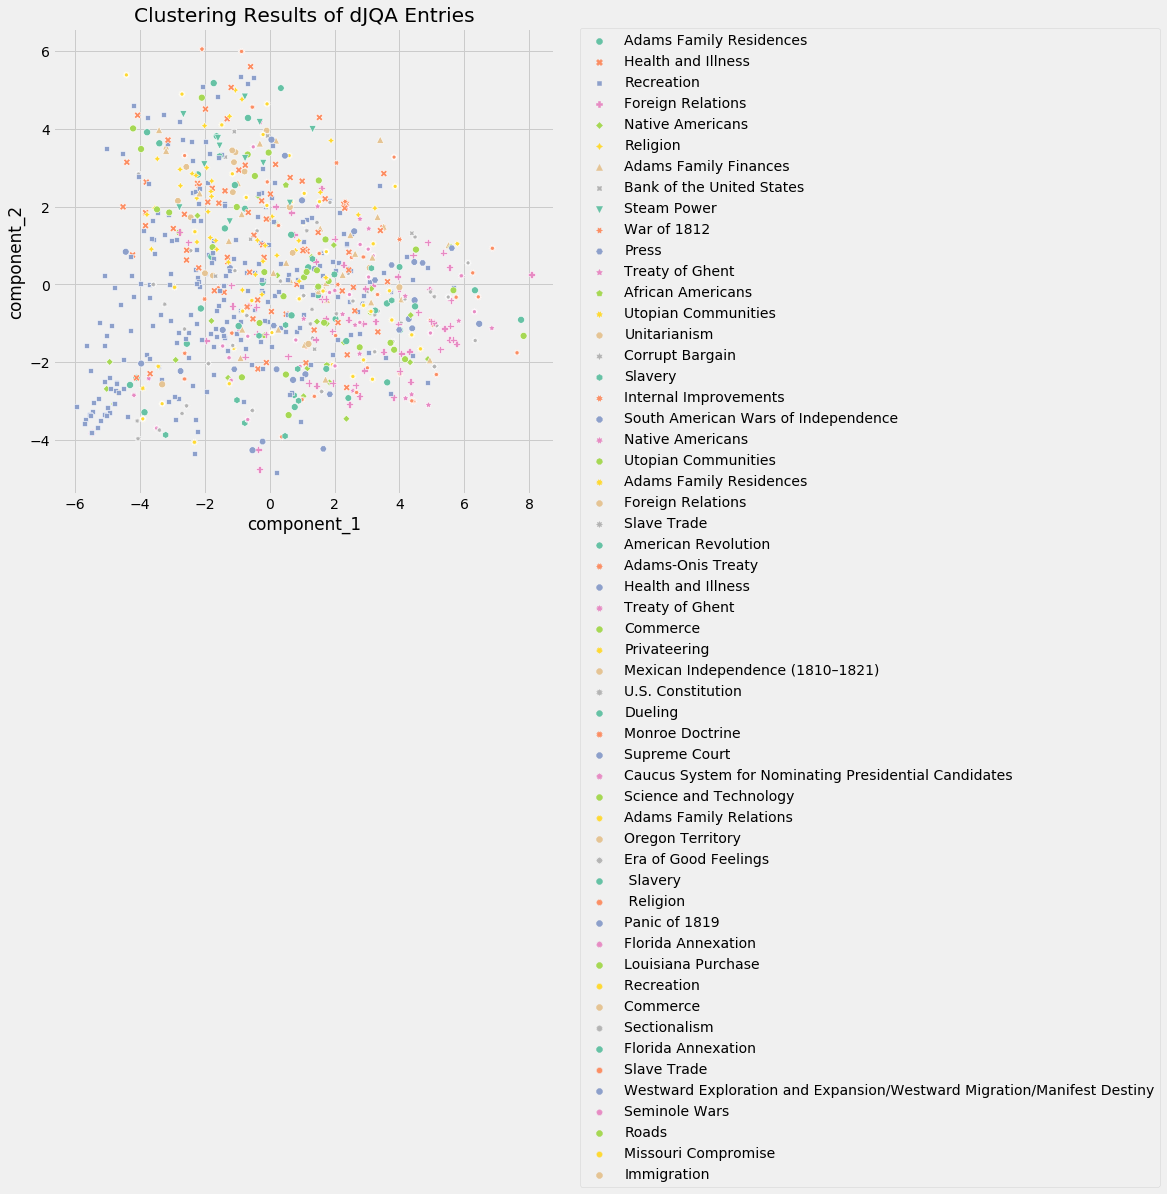

CPU times: user 1.74 s, sys: 157 ms, total: 1.9 s
Wall time: 912 ms


In [4]:
%%time

pcadf = pd.DataFrame(
    pipe['preprocesser'].transform(features),
    columns = ['component_1', 'component_2']
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

fig = sns.scatterplot(
    "component_1",
    "component_2",
    s = 50,
    data = pcadf,
    hue = "true_label",
    style = "true_label",
    palette = "Set2"
)

fig.set_title(
    "Clustering Results of dJQA Entries"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()